In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.evaluation import *
plt.rcParams["figure.figsize"] = (16,9)

In [4]:
data = pd.read_csv('../data/gresearch/raw/train.csv')
data['timestamp'] = pd.to_datetime(data.timestamp, unit='s')
asset_info = pd.read_csv('../data/gresearch/raw/asset_details.csv').sort_values('Asset_ID')
data=(data.merge(asset_info[['Asset_ID', 'Weight']],
                             on='Asset_ID', how='left'))

In [5]:
asset_info

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [6]:
data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight
0,2018-01-01 00:01:00,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2.397895
1,2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,4.304065
2,2018-01-01 00:01:00,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,6.779922
3,2018-01-01 00:01:00,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,1.386294
4,2018-01-01 00:01:00,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2.079442


In [8]:
# Minimum date for plotting - public leaderboard starting period
min_date = pd.to_datetime('2021-06-13 00:00:00')
min_date

Timestamp('2021-06-13 00:00:00')

In [ ]:
for asset in asset_info.Asset_ID.unique():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8))
    
    coin = data[(data.Asset_ID==asset) & (data.timestamp>=min_date)]
    coin = coin.set_index('timestamp')
    #coin_daily = coin.resample('').last()[['Close']]
    #coin_daily['ret'] = coin_daily.Close.diff()/coin_daily.Close.shift(1)
    sns.lineplot(x=coin.index, y=coin.Close, ax=ax[0])
    ax[1].bar(x=coin.index, height=coin.Target, color = ['red' if ret<0 else 'blue' for ret in coin.Target.values])
    fig.suptitle(asset_info[asset_info.Asset_ID==asset].Asset_Name.values[0])

## Cross Validation pipeline

In [100]:
# Get splits
splits = purged_walked_forward_cv(data=data,
                                  train_size_days = 90,
                                  purge_window_days=14,
                                  test_size_days=30,
                                  start_date= "2018-01-01 00:00:000",
                                 dadjust=1440)

In [103]:
len(splits)

11

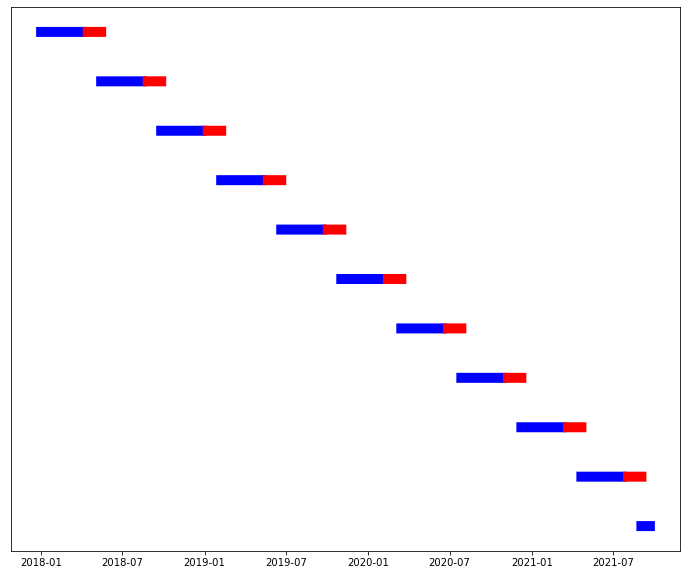

In [106]:
fig, ax = plt.subplots(1,1, figsize=(12,10))

for split in splits:
    
    train_ts = split[0]
    test_ts = split[1]
    fold = split[2]
    
    ax.plot(train_ts, np.repeat(-fold,len(train_ts)), color='blue', linewidth=10.0)
    ax.plot(test_ts, np.repeat(-fold,len(test_ts)), color='red', linewidth=10.0)
    
         
plt.yticks([]);

In [86]:
class BaseCryptoLearner():
    
    def __init__(self, assets=None):
        self.initialized = True
        self.learned_mean = {}
        self.assets = assets
    
    def train(self, data):
        # Just take the target distribution median over the sample
        self.learned_mean = np.mean(data.Target)
    
    def predict(self, X): # Should always be with (AssetID & Timestamp)
        # Predict the learned mean
        pred = pd.DataFrame({'Asset_ID': X.Asset_ID,
                            'timestamp': X.timestamp})
        pred['prediction'] = np.repeat(self.learned_mean, repeats=X.shape[0])
        
        return pred

In [87]:
model = BaseCryptoLearner()

In [102]:
scores = []
for split in splits[:-1]:
    train_ts = split[0]
    test_ts = split[1]
    fold = split[2]
    print(f'Fold {fold}')
    
    train = data[data.timestamp.isin(train_ts)]
    test = data[data.timestamp.isin(test_ts)]
    
    predictions = []
    
    for asset_id in asset_info.Asset_ID.values:
        print(asset_info[asset_info.Asset_ID==asset_id].Asset_Name.values[0])
        coin_train = train[train.Asset_ID==asset_id]
        coin_test = test[test.Asset_ID==asset_id]
        model.train(coin_train)
        predictions.append(model.predict(coin_test))
    
    test = test.merge(pd.concat(predictions), on=['timestamp', 'Asset_ID'], how='left').fillna(0)
        
    score = corr_score(test.Target, test.prediction, test.Weight)
    print(f'Score on test {score}')
    print('--------------\n')
    scores.append(score)

Fold 1
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Classic
IOTA
Litecoin
Maker
Monero
Stellar
TRON
Score on test -0.004687811719540076
--------------

Fold 2
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Classic
IOTA
Litecoin
Maker
Monero
Stellar
TRON
Score on test 0.0011258052449110512
--------------

Fold 3
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Classic
IOTA
Litecoin
Maker
Monero
Stellar
TRON
Score on test 0.000708668956298585
--------------

Fold 4
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Classic
IOTA
Litecoin
Maker
Monero
Stellar
TRON
Score on test 0.0012808217121968901
--------------

Fold 5
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Classic
IOTA
Litecoin
Maker
Monero
Stellar
TRON
Score on test -0.003619759543683936
--------------

Fold 6
Binance Coin
Bitcoin
Bitcoin Cash
Cardano
Dogecoin
EOS.IO
Ethereum
Ethereum Cla

In [ ]:
scores